Top 25 Teams:
                     rating  rating_scaled     conference
team                                                     
Ohio St.        1936.222758     100.000000        Big Ten
Vermont         1926.272249      98.896840   America East
Denver          1921.067482      98.319815  Summit League
Marshall        1905.557706      96.600327       Sun Belt
Dayton          1876.069930      93.331173    Atlantic 10
SMU             1873.638390      93.061601            ACC
Clemson         1862.344304      91.809486            ACC
Wake Forest     1846.617789      90.065970            ACC
Pittsburgh      1840.384804      89.374952            ACC
San Diego       1836.207258      88.911809            WCC
Kansas City     1821.439583      87.274595  Summit League
Massachusetts   1815.944526      86.665387    Atlantic 10
Indiana         1797.442888      84.614208        Big Ten
West Virginia   1793.463171      84.172998       Sun Belt
Penn            1791.528444      83.958505     Ivy League


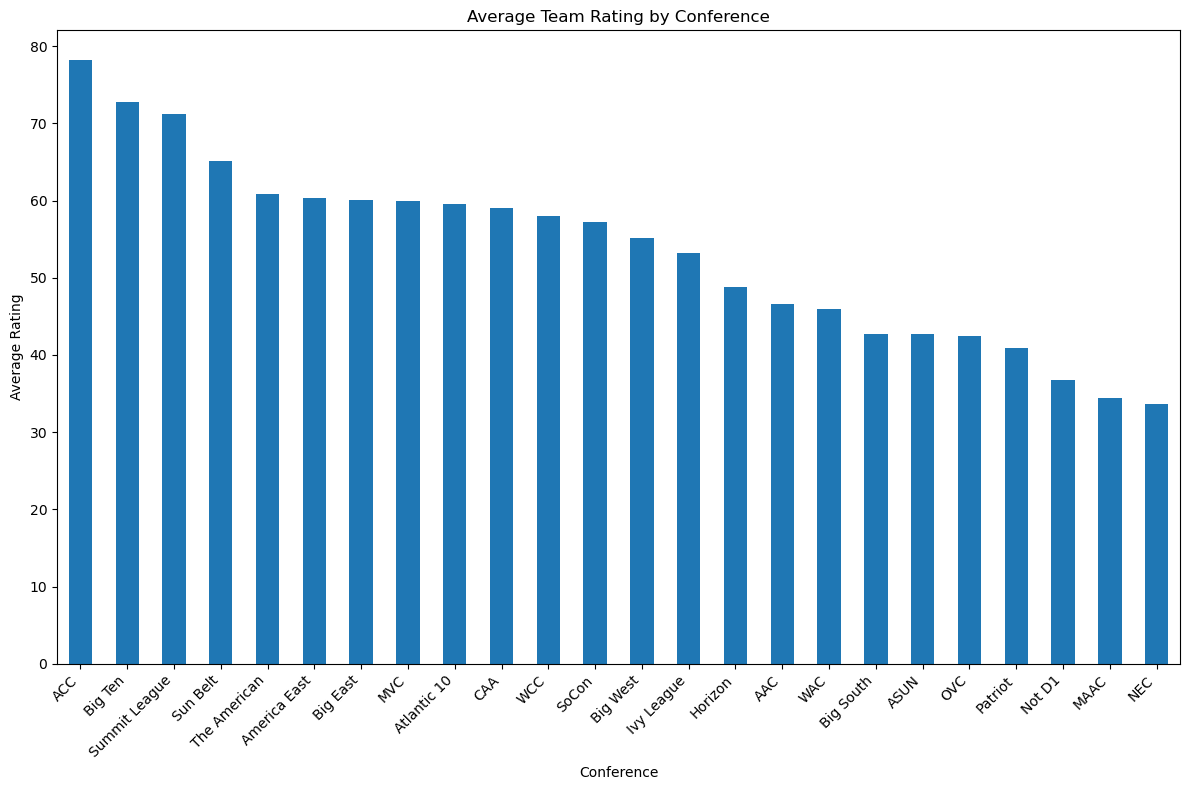

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calculate_team_ratings(df, initial_rating=1500, k_factor=32, iterations=10):
    """
    Calculate team ratings based on game results using an Elo-inspired system
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with columns: home_team, away_team, home_team_score, away_team_score
    initial_rating : float
        Initial rating for all teams
    k_factor : float
        Factor determining how much ratings change after each game
    iterations : int
        Number of times to iterate through all games
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with team ratings
    """
    # Extract unique teams
    all_teams = pd.unique(df[['home_team', 'away_team']].values.ravel('K'))
    
    # Initialize ratings dictionary
    ratings = {team: initial_rating for team in all_teams}
    
    # Define function to calculate expected outcome
    def expected_outcome(rating_a, rating_b):
        return 1 / (1 + 10 ** ((rating_b - rating_a) / 400))
    
    # Define function to determine actual outcome
    def actual_outcome(score_a, score_b):
        if score_a > score_b:
            return 1.0
        elif score_a < score_b:
            return 0.0
        else:
            return 0.5  # Draw
    
    # Iterate through games multiple times for convergence
    for _ in range(iterations):
        for _, row in df.iterrows():
            home_team = row['home_team']
            away_team = row['away_team']
            home_score = row['home_team_score']
            away_score = row['away_team_score']
            
            # Get current ratings
            home_rating = ratings[home_team]
            away_rating = ratings[away_team]
            
            # Calculate expected outcomes
            home_expected = expected_outcome(home_rating, away_rating)
            away_expected = expected_outcome(away_rating, home_rating)
            
            # Calculate actual outcomes
            home_actual = actual_outcome(home_score, away_score)
            away_actual = actual_outcome(away_score, home_score)
            
            # Update ratings
            ratings[home_team] += k_factor * (home_actual - home_expected)
            ratings[away_team] += k_factor * (away_actual - away_expected)
    
    # Create DataFrame from ratings dictionary
    ratings_df = pd.DataFrame.from_dict(ratings, orient='index', columns=['rating'])
    ratings_df.index.name = 'team'
    
    # Scale ratings from 1 to 100
    min_rating = ratings_df['rating'].min()
    max_rating = ratings_df['rating'].max()
    ratings_df['rating_scaled'] = 1 + 99 * (ratings_df['rating'] - min_rating) / (max_rating - min_rating)
    
    # Add conference information
    team_conferences = {}
    for _, row in df.iterrows():
        team_conferences[row['home_team']] = row['home_team_conference']
        team_conferences[row['away_team']] = row['away_team_conference']
    
    ratings_df['conference'] = pd.Series(team_conferences)
    
    # Sort by rating (descending)
    return ratings_df.sort_values('rating_scaled', ascending=False)

def analyze_ratings(ratings_df):
    """
    Analyze team ratings by conference and plot visualizations
    
    Parameters:
    -----------
    ratings_df : pandas.DataFrame
        DataFrame with team ratings and conference information
    
    Returns:
    --------
    tuple
        Conference summary DataFrame and top teams DataFrame
    """
    # Conference summary statistics
    conf_stats = ratings_df.groupby('conference')['rating_scaled'].agg(
        ['count', 'mean', 'median', 'min', 'max']
    ).sort_values('mean', ascending=False)
    
    # Top teams overall
    top_teams = ratings_df.head(25)
    
    # Plot conference average ratings
    plt.figure(figsize=(12, 8))
    conf_stats['mean'].plot(kind='bar')
    plt.title('Average Team Rating by Conference')
    plt.ylabel('Average Rating')
    plt.xlabel('Conference')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    return conf_stats, top_teams

# Example usage
# Assuming 'soccer_data' is the DataFrame with the game results
soccer_data = pd.read_csv(r"C:\Users\maxwe\Player and Team Ratings\NCAA\ncaa_mens_scores_2024.csv")
ratings = calculate_team_ratings(soccer_data)
conf_stats, top_teams = analyze_ratings(ratings)
print("Top 25 Teams:")
print(top_teams)
print("\nConference Rankings:")
print(conf_stats)